In [1]:
import numpy as np
import keras
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Dropout
from keras_contrib.layers.crf import CRF
import matplotlib.pyplot as plt
import os
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau
import json
from keras import metrics
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

Using TensorFlow backend.


In [2]:
sample_x = []
sample_y = []
vocabs = {'UNK'}
datas = []
for line in open('/home/wcb/nerXY/train_data/1.1_train.txt', 'r', encoding='utf-8'):
    line = line.rstrip().split('\t')
    if not line:
        continue
    char = line[0]
    if not char:
        continue
    cate = line[-1]
    sample_x.append(char)
    sample_y.append(cate)
    vocabs.add(char)
    if char in ['.', '?', '!']:
        datas.append([sample_x, sample_y])
        sample_x = []
        sample_y = []
word_dict = {wd:index for index,wd in enumerate(list(vocabs))}

In [3]:
file = open('/home/wcb/nerXY/word_dict/1.1_word_dict.txt', 'w') 
for k,v in word_dict.items():
    file.write(str(v) + ' ' + str(k) + '\n')
file.close()

In [4]:
class_dict = {'O':0,
              'I-ROCK':1,
              'I-MEM':2,
              'I-NMEN':3,
              'I-ISOE':4,
              'I-OTHE':5,
              'I-GEOTS':6,
              'I-ISOAGE':7,
              'I-LOCA':8,
              'I-GEOSTR':9,
              'I-GEOUN':10,
              'I-FLUID':11,
              'I-GA':12
             }
x_train = [[word_dict[char] for char in data[0]] for data in datas]
y_train = [[class_dict[label] for label in data[1]] for data in datas]
x_train = pad_sequences(x_train, maxlen=40, padding='post')
y = pad_sequences(y_train, maxlen=40, padding='post')
y_train = np.expand_dims(y, axis=2)

In [5]:
embeddings_dict = {}
with open('/home/wcb/nerXY/w2v/1.1_w2v.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.strip().split(' ')
        if len(values) < 72:
            continue
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_dict[word] = coefs
print('Found %s word vectors.' % len(embeddings_dict))

embedding_matrix = np.zeros((len(word_dict) + 1, 72))
for word, i in word_dict.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Found 3796 word vectors.


In [6]:
model = Sequential()
embedding_layer = Embedding(len(word_dict) + 1,
                            72,
                            weights=[embedding_matrix],
                            input_length=40,
                            trainable=False,
                            mask_zero=True)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(16, return_sequences=True,  activation='softsign')))
model.add(Dropout(0.5))
model.add(TimeDistributed(Dense(len(class_dict))))
crf_layer = CRF(len(class_dict), sparse_target=True)
model.add(crf_layer)
model.compile(optimizer='AdaGrad', loss=crf_layer.loss_function, metrics=[crf_layer.accuracy])
model.summary()










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



/Users/yvse/opt/anaconda3/envs/keras/lib/python3.7/site-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/Users/yvse/opt/anaconda3/envs/keras/lib/python3.7/site-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 72)            273528    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40, 32)            11392     
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 32)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 13)            429       
_________________________________________________________________
crf_1 (CRF)                  (None, 40, 13)            377       
Total params: 285,726
Trainable params: 12,198
Non-trainable params: 273,528
_________________________________________________________________


In [7]:
history = model.fit(x_train[:], y_train[:], validation_split=0.10, batch_size=64, epochs=1000)



Train on 1194 samples, validate on 133 samples
Epoch 1/1000
1194/1194 [==============================] - 2s 2ms/step - loss: 4.7355 - crf_viterbi_accuracy: 0.7028 - val_loss: 4.8437 - val_crf_viterbi_accuracy: 0.7869
Epoch 2/1000
1194/1194 [==============================] - 1s 650us/step - loss: 4.3950 - crf_viterbi_accuracy: 0.7861 - val_loss: 4.8018 - val_crf_viterbi_accuracy: 0.7869
Epoch 3/1000
1194/1194 [==============================] - 1s 690us/step - loss: 4.3605 - crf_viterbi_accuracy: 0.7862 - val_loss: 4.7817 - val_crf_viterbi_accuracy: 0.7869
Epoch 4/1000
1194/1194 [==============================] - 1s 636us/step - loss: 4.3365 - crf_viterbi_accuracy: 0.7864 - val_loss: 4.7631 - val_crf_viterbi_accuracy: 0.7869
Epoch 5/1000
1194/1194 [==============================] - 1s 642us/step - loss: 4.3162 - crf_viterbi_accuracy: 0.7864 - val_loss: 4.7517 - val_crf_viterbi_accuracy: 0.7869
Epoch 6/1000
1194/1194 [==============================] - 1s 634us/step - loss: 4.3058 - crf_

Epoch 46/1000
1194/1194 [==============================] - 1s 603us/step - loss: 3.9691 - crf_viterbi_accuracy: 0.8014 - val_loss: 4.4574 - val_crf_viterbi_accuracy: 0.7979
Epoch 47/1000
1194/1194 [==============================] - 1s 607us/step - loss: 3.9690 - crf_viterbi_accuracy: 0.8023 - val_loss: 4.4564 - val_crf_viterbi_accuracy: 0.7986
Epoch 48/1000
1194/1194 [==============================] - 1s 610us/step - loss: 3.9599 - crf_viterbi_accuracy: 0.8032 - val_loss: 4.4518 - val_crf_viterbi_accuracy: 0.8004
Epoch 49/1000
1194/1194 [==============================] - 1s 612us/step - loss: 3.9563 - crf_viterbi_accuracy: 0.8014 - val_loss: 4.4483 - val_crf_viterbi_accuracy: 0.8001
Epoch 50/1000
1194/1194 [==============================] - 1s 612us/step - loss: 3.9544 - crf_viterbi_accuracy: 0.8013 - val_loss: 4.4444 - val_crf_viterbi_accuracy: 0.8022
Epoch 51/1000
1194/1194 [==============================] - 1s 608us/step - loss: 3.9540 - crf_viterbi_accuracy: 0.8036 - val_loss: 4.44

1194/1194 [==============================] - 1s 621us/step - loss: 3.7827 - crf_viterbi_accuracy: 0.8342 - val_loss: 4.3215 - val_crf_viterbi_accuracy: 0.8446
Epoch 141/1000
1194/1194 [==============================] - 1s 618us/step - loss: 3.7800 - crf_viterbi_accuracy: 0.8395 - val_loss: 4.3204 - val_crf_viterbi_accuracy: 0.8449
Epoch 142/1000
1194/1194 [==============================] - 1s 615us/step - loss: 3.7784 - crf_viterbi_accuracy: 0.8372 - val_loss: 4.3197 - val_crf_viterbi_accuracy: 0.8449
Epoch 143/1000
1194/1194 [==============================] - 1s 623us/step - loss: 3.7720 - crf_viterbi_accuracy: 0.8368 - val_loss: 4.3181 - val_crf_viterbi_accuracy: 0.8457
Epoch 144/1000
1194/1194 [==============================] - 1s 625us/step - loss: 3.7712 - crf_viterbi_accuracy: 0.8394 - val_loss: 4.3168 - val_crf_viterbi_accuracy: 0.8454
Epoch 145/1000
1194/1194 [==============================] - 1s 626us/step - loss: 3.7721 - crf_viterbi_accuracy: 0.8388 - val_loss: 4.3167 - val_

1194/1194 [==============================] - 1s 658us/step - loss: 3.7004 - crf_viterbi_accuracy: 0.8567 - val_loss: 4.2688 - val_crf_viterbi_accuracy: 0.8498
Epoch 235/1000
1194/1194 [==============================] - 1s 656us/step - loss: 3.7056 - crf_viterbi_accuracy: 0.8550 - val_loss: 4.2681 - val_crf_viterbi_accuracy: 0.8498
Epoch 236/1000
1194/1194 [==============================] - 1s 651us/step - loss: 3.7006 - crf_viterbi_accuracy: 0.8549 - val_loss: 4.2683 - val_crf_viterbi_accuracy: 0.8498
Epoch 237/1000
1194/1194 [==============================] - 1s 655us/step - loss: 3.7063 - crf_viterbi_accuracy: 0.8547 - val_loss: 4.2673 - val_crf_viterbi_accuracy: 0.8498
Epoch 238/1000
1194/1194 [==============================] - 1s 654us/step - loss: 3.7006 - crf_viterbi_accuracy: 0.8568 - val_loss: 4.2669 - val_crf_viterbi_accuracy: 0.8505
Epoch 239/1000
1194/1194 [==============================] - 1s 656us/step - loss: 3.6992 - crf_viterbi_accuracy: 0.8586 - val_loss: 4.2671 - val_

1194/1194 [==============================] - 1s 656us/step - loss: 3.6599 - crf_viterbi_accuracy: 0.8687 - val_loss: 4.2413 - val_crf_viterbi_accuracy: 0.8542
Epoch 329/1000
1194/1194 [==============================] - 1s 659us/step - loss: 3.6676 - crf_viterbi_accuracy: 0.8654 - val_loss: 4.2400 - val_crf_viterbi_accuracy: 0.8542
Epoch 330/1000
1194/1194 [==============================] - 1s 658us/step - loss: 3.6600 - crf_viterbi_accuracy: 0.8690 - val_loss: 4.2404 - val_crf_viterbi_accuracy: 0.8538
Epoch 331/1000
1194/1194 [==============================] - 1s 652us/step - loss: 3.6616 - crf_viterbi_accuracy: 0.8706 - val_loss: 4.2404 - val_crf_viterbi_accuracy: 0.8542
Epoch 332/1000
1194/1194 [==============================] - 1s 660us/step - loss: 3.6634 - crf_viterbi_accuracy: 0.8666 - val_loss: 4.2397 - val_crf_viterbi_accuracy: 0.8542
Epoch 333/1000
1194/1194 [==============================] - 1s 661us/step - loss: 3.6572 - crf_viterbi_accuracy: 0.8686 - val_loss: 4.2394 - val_

1194/1194 [==============================] - 1s 659us/step - loss: 3.6321 - crf_viterbi_accuracy: 0.8784 - val_loss: 4.2243 - val_crf_viterbi_accuracy: 0.8657
Epoch 423/1000
1194/1194 [==============================] - 1s 656us/step - loss: 3.6335 - crf_viterbi_accuracy: 0.8742 - val_loss: 4.2244 - val_crf_viterbi_accuracy: 0.8653
Epoch 424/1000
1194/1194 [==============================] - 1s 654us/step - loss: 3.6349 - crf_viterbi_accuracy: 0.8787 - val_loss: 4.2243 - val_crf_viterbi_accuracy: 0.8653
Epoch 425/1000
1194/1194 [==============================] - 1s 655us/step - loss: 3.6329 - crf_viterbi_accuracy: 0.8784 - val_loss: 4.2248 - val_crf_viterbi_accuracy: 0.8653
Epoch 426/1000
1194/1194 [==============================] - 1s 655us/step - loss: 3.6364 - crf_viterbi_accuracy: 0.8791 - val_loss: 4.2251 - val_crf_viterbi_accuracy: 0.8657
Epoch 427/1000
1194/1194 [==============================] - 1s 657us/step - loss: 3.6377 - crf_viterbi_accuracy: 0.8773 - val_loss: 4.2241 - val_

1194/1194 [==============================] - 1s 638us/step - loss: 3.6170 - crf_viterbi_accuracy: 0.8820 - val_loss: 4.2148 - val_crf_viterbi_accuracy: 0.8757
Epoch 517/1000
1194/1194 [==============================] - 1s 639us/step - loss: 3.6150 - crf_viterbi_accuracy: 0.8835 - val_loss: 4.2145 - val_crf_viterbi_accuracy: 0.8754
Epoch 518/1000
1194/1194 [==============================] - 1s 640us/step - loss: 3.6182 - crf_viterbi_accuracy: 0.8816 - val_loss: 4.2146 - val_crf_viterbi_accuracy: 0.8754
Epoch 519/1000
1194/1194 [==============================] - 1s 638us/step - loss: 3.6136 - crf_viterbi_accuracy: 0.8854 - val_loss: 4.2145 - val_crf_viterbi_accuracy: 0.8757
Epoch 520/1000
1194/1194 [==============================] - 1s 650us/step - loss: 3.6151 - crf_viterbi_accuracy: 0.8844 - val_loss: 4.2146 - val_crf_viterbi_accuracy: 0.8750
Epoch 521/1000
1194/1194 [==============================] - 1s 661us/step - loss: 3.6198 - crf_viterbi_accuracy: 0.8829 - val_loss: 4.2147 - val_

1194/1194 [==============================] - 1s 668us/step - loss: 3.6033 - crf_viterbi_accuracy: 0.8865 - val_loss: 4.2097 - val_crf_viterbi_accuracy: 0.8775
Epoch 611/1000
1194/1194 [==============================] - 1s 658us/step - loss: 3.6051 - crf_viterbi_accuracy: 0.8862 - val_loss: 4.2088 - val_crf_viterbi_accuracy: 0.8779
Epoch 612/1000
1194/1194 [==============================] - 1s 652us/step - loss: 3.6048 - crf_viterbi_accuracy: 0.8857 - val_loss: 4.2086 - val_crf_viterbi_accuracy: 0.8779
Epoch 613/1000
1194/1194 [==============================] - 1s 657us/step - loss: 3.6040 - crf_viterbi_accuracy: 0.8886 - val_loss: 4.2087 - val_crf_viterbi_accuracy: 0.8779
Epoch 614/1000
1194/1194 [==============================] - 1s 657us/step - loss: 3.6035 - crf_viterbi_accuracy: 0.8862 - val_loss: 4.2091 - val_crf_viterbi_accuracy: 0.8779
Epoch 615/1000
1194/1194 [==============================] - 1s 657us/step - loss: 3.6003 - crf_viterbi_accuracy: 0.8878 - val_loss: 4.2086 - val_

1194/1194 [==============================] - 1s 728us/step - loss: 3.5964 - crf_viterbi_accuracy: 0.8925 - val_loss: 4.2089 - val_crf_viterbi_accuracy: 0.8807
Epoch 705/1000
1194/1194 [==============================] - 1s 722us/step - loss: 3.5925 - crf_viterbi_accuracy: 0.8898 - val_loss: 4.2088 - val_crf_viterbi_accuracy: 0.8811
Epoch 706/1000
1194/1194 [==============================] - 1s 713us/step - loss: 3.5940 - crf_viterbi_accuracy: 0.8921 - val_loss: 4.2084 - val_crf_viterbi_accuracy: 0.8822
Epoch 707/1000
1194/1194 [==============================] - 1s 704us/step - loss: 3.5878 - crf_viterbi_accuracy: 0.8899 - val_loss: 4.2087 - val_crf_viterbi_accuracy: 0.8832
Epoch 708/1000
1194/1194 [==============================] - 1s 696us/step - loss: 3.5927 - crf_viterbi_accuracy: 0.8911 - val_loss: 4.2085 - val_crf_viterbi_accuracy: 0.8828
Epoch 709/1000
1194/1194 [==============================] - 1s 712us/step - loss: 3.5922 - crf_viterbi_accuracy: 0.8905 - val_loss: 4.2082 - val_

1194/1194 [==============================] - 1s 661us/step - loss: 3.5814 - crf_viterbi_accuracy: 0.8954 - val_loss: 4.2074 - val_crf_viterbi_accuracy: 0.8830
Epoch 799/1000
1194/1194 [==============================] - 1s 655us/step - loss: 3.5819 - crf_viterbi_accuracy: 0.8953 - val_loss: 4.2073 - val_crf_viterbi_accuracy: 0.8837
Epoch 800/1000
1194/1194 [==============================] - 1s 659us/step - loss: 3.5783 - crf_viterbi_accuracy: 0.8981 - val_loss: 4.2080 - val_crf_viterbi_accuracy: 0.8834
Epoch 801/1000
1194/1194 [==============================] - 1s 662us/step - loss: 3.5853 - crf_viterbi_accuracy: 0.8943 - val_loss: 4.2078 - val_crf_viterbi_accuracy: 0.8834
Epoch 802/1000
1194/1194 [==============================] - 1s 658us/step - loss: 3.5820 - crf_viterbi_accuracy: 0.8933 - val_loss: 4.2079 - val_crf_viterbi_accuracy: 0.8826
Epoch 803/1000
1194/1194 [==============================] - 1s 660us/step - loss: 3.5864 - crf_viterbi_accuracy: 0.8927 - val_loss: 4.2080 - val_

1194/1194 [==============================] - 1s 661us/step - loss: 3.5721 - crf_viterbi_accuracy: 0.8972 - val_loss: 4.2077 - val_crf_viterbi_accuracy: 0.8853
Epoch 893/1000
1194/1194 [==============================] - 1s 654us/step - loss: 3.5736 - crf_viterbi_accuracy: 0.8979 - val_loss: 4.2077 - val_crf_viterbi_accuracy: 0.8833
Epoch 894/1000
1194/1194 [==============================] - 1s 655us/step - loss: 3.5739 - crf_viterbi_accuracy: 0.8991 - val_loss: 4.2080 - val_crf_viterbi_accuracy: 0.8822
Epoch 895/1000
1194/1194 [==============================] - 1s 656us/step - loss: 3.5707 - crf_viterbi_accuracy: 0.8994 - val_loss: 4.2083 - val_crf_viterbi_accuracy: 0.8819
Epoch 896/1000
1194/1194 [==============================] - 1s 656us/step - loss: 3.5692 - crf_viterbi_accuracy: 0.8961 - val_loss: 4.2085 - val_crf_viterbi_accuracy: 0.8822
Epoch 897/1000
1194/1194 [==============================] - 1s 659us/step - loss: 3.5696 - crf_viterbi_accuracy: 0.8975 - val_loss: 4.2085 - val_

1194/1194 [==============================] - 1s 676us/step - loss: 3.5618 - crf_viterbi_accuracy: 0.9024 - val_loss: 4.2094 - val_crf_viterbi_accuracy: 0.8861
Epoch 987/1000
1194/1194 [==============================] - 1s 676us/step - loss: 3.5694 - crf_viterbi_accuracy: 0.8994 - val_loss: 4.2096 - val_crf_viterbi_accuracy: 0.8850
Epoch 988/1000
1194/1194 [==============================] - 1s 677us/step - loss: 3.5669 - crf_viterbi_accuracy: 0.9007 - val_loss: 4.2098 - val_crf_viterbi_accuracy: 0.8850
Epoch 989/1000
1194/1194 [==============================] - 1s 670us/step - loss: 3.5712 - crf_viterbi_accuracy: 0.8969 - val_loss: 4.2089 - val_crf_viterbi_accuracy: 0.8853
Epoch 990/1000
1194/1194 [==============================] - 1s 680us/step - loss: 3.5721 - crf_viterbi_accuracy: 0.8987 - val_loss: 4.2088 - val_crf_viterbi_accuracy: 0.8850
Epoch 991/1000
1194/1194 [==============================] - 1s 676us/step - loss: 3.5673 - crf_viterbi_accuracy: 0.9019 - val_loss: 4.2093 - val_

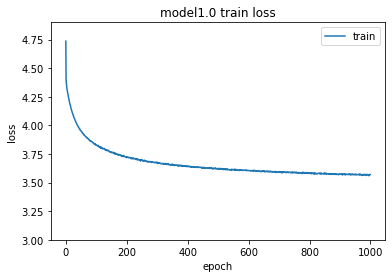

In [10]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.title('model1.0 train loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train'], loc='upper right')
pyplot.ylim([3,4.9])

In [12]:
model.save('/home/wcb/nerXY/model/model1.1.h5')